# Social media sentiment analysis

Customer sentiment related to Australia's 'big 4' banks is arguably at an all-time low. The Banking Royal Commission put the spotlight on banking practices that fell well short of customer expectations and regulatory requirements, including charging financial advice fees for customers who were not receiving that service as well as charging insurance premuims for dead people. So when I wanted to develop an application to measure customer sentiment it made sense to use one of these banks as the source of my data.

The application below analyses a weeks worth of Tweets relating to one of these banks (NAB) to get an understanding of chaning sentiment over time, as well as the topics that are driving that sentiment. The application uses the Tweepy Twitter API to collect the tweets, the NLTK Natural Language Processing Toolkit to analyse the text and the Vader library to analyse sentiment.

The first step requires installing and importing required libraries and initialising credential for the Tweepy API:

In [1]:
!pip install tweepy nltk google-cloud-language python-telegram-bot vaderSentiment

     |████████████████████████████████| 92kB 17.5MB/s eta 0:00:01
     |████████████████████████████████| 348kB 24.9MB/s eta 0:00:01
     |████████████████████████████████| 133kB 38.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 25.8MB/s eta 0:00:01
     |████████████████████████████████| 153kB 27.5MB/s eta 0:00:01
     |████████████████████████████████| 81kB 29.0MB/s eta 0:00:01
     |████████████████████████████████| 102kB 33.6MB/s ta 0:00:01
     |████████████████████████████████| 81kB 32.2MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/9e/3d/a2/1bec8bb7db80ab3216dbc33092bb7ccd0debfb8ba42b5668d5
Successfully built googleapis-common-protos


In [2]:
from tweepy import OAuthHandler
import tweepy
import pandas as pd
import re
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime, timedelta

In [3]:
# The code was removed by Watson Studio for sharing.

### Pull tweets into a dataframe

Next we call the API with the keyword @NAB to search for all tweets related to the bank. Twitter only allows a week or two of tweets to be extracted without a premuim account so we'll settle with a start date of 7 days prior to today and a maximum of 10000 tweets.

In [4]:
auth=OAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN,ACCESS_TOKEN_SECRET)
api=tweepy.API(auth)

In [5]:
keyword = '@NAB -filter:retweets'
total_tweets = 10000

def search_tweets(keyword, total_tweets):
    today_datetime = datetime.today().now()
    start_datetime = today_datetime - timedelta(days=7)
    today_date = today_datetime.strftime('%Y-%m-%d')
    start_date = start_datetime.strftime('%Y-%m-%d')
    search_result = tweepy.Cursor(api.search, 
                                  tweet_mode='extended',
                                  q=keyword, 
                                  since=start_date, 
                                  result_type='recent', 
                                  lang='en').items(total_tweets)
    return search_result

tweets=search_tweets(keyword,total_tweets)


We create a list of all attributes of each tweet:

In [7]:
tweetlist = [[tweet.id,
              tweet.full_text,
              tweet.retweet_count,
              tweet.favorite_count,
              tweet.source,
              tweet.created_at,
              tweet.user.id,
              tweet.user.screen_name,
              tweet.user.name,
              tweet.user.created_at,
              tweet.user.description,
              tweet.user.followers_count,
              tweet.user.friends_count,
              tweet.user.location,
              tweet.user.time_zone] for tweet in tweets]

Then pull that into a dataframe for analysis:

In [9]:
df = pd.DataFrame(data=tweetlist, columns=['id','text','retweets','favorite_count','source','created_at','userid','username','name','user_joined','user_desc','user_followers','user_friends','user_location','user_timezone'])

In [10]:
print(df.shape)
df.head()

(355, 15)


,id,text,retweets,favorite_count,source,created_at,userid,username,name,user_joined,user_desc,user_followers,user_friends,user_location,user_timezone
0,1168356142298423296,@NAB on hold... business banking... you're exp...,0,0,Twitter Web App,2019-09-02 02:53:05,17205672,bacifarfalla,bacifarfalla,2008-11-06 04:36:00,,106,398,,None
1,1168344812321296384,@NAB Not only about me. This is much much bigg...,0,0,Twitter for Android,2019-09-02 02:08:04,954266247218130944,Unblackened,P8RIOT,2018-01-19 08:16:17,,351,430,,None
2,1168313581554696192,"""More than half of the 40 funds on the fat cat...",0,0,Twitter Web App,2019-09-02 00:03:58,1148051655893454848,ConsumersSuper,Super Consumers Australia,2019-07-08 02:10:19,"Based at @choiceaustralia, we are a consumer a...",126,74,"Sydney, New South Wales",None
3,1168306763264716802,"@NAB Seems to be working on Firefox , but not ...",0,0,Twitter for Android,2019-09-01 23:36:53,20973167,Milkwood_Nick,Nick Ritar,2009-02-16 09:31:19,"Mushroom growing, bee keeping, veggie gardenin...",1899,926,Milkwood,None
4,1168297516477112322,3 of the big 4 report mortgage book contractio...,0,0,Hootsuite Inc.,2019-09-01 23:00:08,2419772598,MrtgBusiness,Mortgage Business,2014-03-31 01:28:06,The leading resource for those involved in the...,492,13,"Sydney, Australia",None


So we have 414 tweets in our data set

### Add sentiment rating for each tweet using Vader

We've used the Vader library for sentiment analysis. It's simple to use and performs fairly well on the shorthand text you get from Twitter. 

In [11]:
#Initialise the analyser object:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

Let's see what the sentiment is for one random tweet:

In [12]:
print(df.text[26])
print('Sentiment =',analyser.polarity_scores(df.text[26]).get('compound'))

@AFL @NAB Fog should have been in there.
Sentiment = 0.0


0.9136 is very postive. Run the sentiment analyser for the whole dataframe then look a few results:

In [13]:
sentiment_score = df.apply(lambda row: analyser.polarity_scores(row['text']).get('compound'), axis=1)
sentiment_score.head()

0    0.3612
1    0.2960
2    0.0000
3    0.0000
4    0.0000
dtype: float64

In the first five tweets we have a couple of negative tweets and a three neutral tweets. We'll now add the sentiment as a column to the dataframe:

In [14]:
df['sentiment_score'] = sentiment_score
df.head()

,id,text,retweets,favorite_count,source,created_at,userid,username,name,user_joined,user_desc,user_followers,user_friends,user_location,user_timezone,sentiment_score
0,1168356142298423296,@NAB on hold... business banking... you're exp...,0,0,Twitter Web App,2019-09-02 02:53:05,17205672,bacifarfalla,bacifarfalla,2008-11-06 04:36:00,,106,398,,None,0.3612
1,1168344812321296384,@NAB Not only about me. This is much much bigg...,0,0,Twitter for Android,2019-09-02 02:08:04,954266247218130944,Unblackened,P8RIOT,2018-01-19 08:16:17,,351,430,,None,0.2960
2,1168313581554696192,"""More than half of the 40 funds on the fat cat...",0,0,Twitter Web App,2019-09-02 00:03:58,1148051655893454848,ConsumersSuper,Super Consumers Australia,2019-07-08 02:10:19,"Based at @choiceaustralia, we are a consumer a...",126,74,"Sydney, New South Wales",None,0.0000
3,1168306763264716802,"@NAB Seems to be working on Firefox , but not ...",0,0,Twitter for Android,2019-09-01 23:36:53,20973167,Milkwood_Nick,Nick Ritar,2009-02-16 09:31:19,"Mushroom growing, bee keeping, veggie gardenin...",1899,926,Milkwood,None,0.0000
4,1168297516477112322,3 of the big 4 report mortgage book contractio...,0,0,Hootsuite Inc.,2019-09-01 23:00:08,2419772598,MrtgBusiness,Mortgage Business,2014-03-31 01:28:06,The leading resource for those involved in the...,492,13,"Sydney, Australia",None,0.0000


It will be useful later when we graph the sentiment for each day to be able to get the hashtags relating to that day. Then when we see a drop or a spike in sentiment we can look at the topics that drove that sentiment via the hashtags

In [15]:
#Function which takes a date and returns hashtags for that date
def gethashtags(date):
    
    #convert the date string to datetime in order to add one day, then convert back to string
    dt = datetime.strptime(date, "%Y-%m-%d")
    dt2 = dt + timedelta(days=1)
    date2 = datetime.strftime(dt2, "%Y-%m-%d")
    
    text = df[(df['created_at'] > date) & (df['created_at'] < date2)].text.to_string()
    hashtags = [word[0:] for word in text.split() if word[0] == '#']
    return hashtags

Lets see what the hashtags are for yesterday as an example:

In [16]:
gethashtags('2019-08-21')

[]

### Graph mean daily sentiment

Let's now graph mean sentiment changes over the past week. First we'll group the tweets by day:

In [19]:
daily_df = df.resample('D',on='created_at').mean()
daily_df.head()

,id,retweets,favorite_count,userid,user_followers,user_friends,sentiment_score
created_at,,,,,,,
2019-08-26,1.165922e+18,1.016667,3.733333,4.279232e+17,14145.733333,1416.800000,0.029208
2019-08-27,1.166325e+18,1.900000,2.350000,3.227601e+17,1211.600000,1025.600000,0.152460
2019-08-28,1.166708e+18,1.275000,3.775000,2.317387e+17,19087.350000,1897.800000,0.206795
2019-08-29,1.166981e+18,0.888889,1.809524,3.548489e+17,12635.349206,1070.301587,0.018089
2019-08-30,1.167327e+18,1.239130,14.076087,2.637632e+17,34579.858696,1250.923913,0.204102


In [20]:
import matplotlib.pyplot as plt
import numpy as np

Then we can plot the graph using the MatPlotLib library, adding a label showing the hashtags relevant for that day:

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


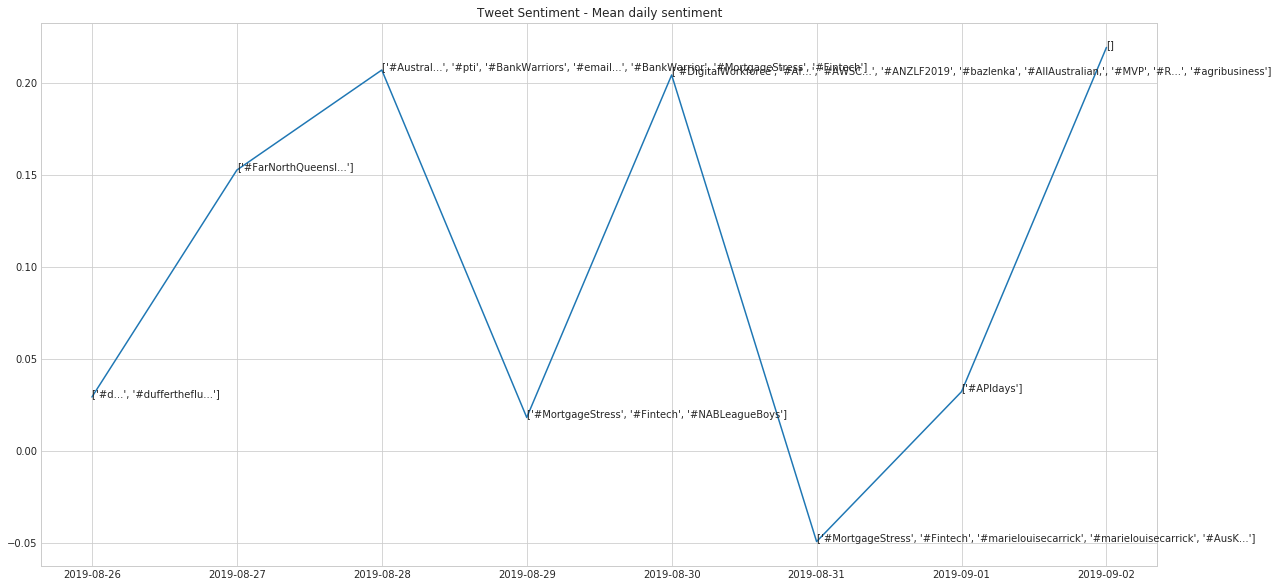

In [21]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20, 10))
plt.plot(daily_df.index, daily_df.sentiment_score)
plt.title("Tweet Sentiment - Mean daily sentiment")

#plot the hashtags associated with each day on the graph
for day in daily_df.index:
    daystring = day.strftime('%Y-%m-%d')
    plt.text(daystring, daily_df.loc[day]['sentiment_score'],gethashtags(daystring))

#FinTech and #Mortgagestress relate to positive tweets regarding potential fintech solutions to the problem of mortgage stress. 
The major negative tweets related to the Clydesdale bank 'Tailored Business Loan scam' which has attracted negative media attention

### Graph total, positive and negative tweet counts

In addition to mean daily tweet sentiment, the ratio of postive to negative tweets may be interesting as it give's a sense of the the volume of activity.

In [22]:
def sentiment_category(sentiment_score):
    if sentiment_score >= 0.05:
        return "positive"
    if (sentiment_score <0.05) and (sentiment_score>-0.05):
        return "neutral"
    if (sentiment_score <=-0.05):
        return "negative"
    

In [23]:
sentiment = df.apply(lambda row: sentiment_category(row['sentiment_score']),axis=1)
df['sentiment']=sentiment
df.head()

,id,text,retweets,favorite_count,source,created_at,userid,username,name,user_joined,user_desc,user_followers,user_friends,user_location,user_timezone,sentiment_score,sentiment
0,1168356142298423296,@NAB on hold... business banking... you're exp...,0,0,Twitter Web App,2019-09-02 02:53:05,17205672,bacifarfalla,bacifarfalla,2008-11-06 04:36:00,,106,398,,None,0.3612,positive
1,1168344812321296384,@NAB Not only about me. This is much much bigg...,0,0,Twitter for Android,2019-09-02 02:08:04,954266247218130944,Unblackened,P8RIOT,2018-01-19 08:16:17,,351,430,,None,0.2960,positive
2,1168313581554696192,"""More than half of the 40 funds on the fat cat...",0,0,Twitter Web App,2019-09-02 00:03:58,1148051655893454848,ConsumersSuper,Super Consumers Australia,2019-07-08 02:10:19,"Based at @choiceaustralia, we are a consumer a...",126,74,"Sydney, New South Wales",None,0.0000,neutral
3,1168306763264716802,"@NAB Seems to be working on Firefox , but not ...",0,0,Twitter for Android,2019-09-01 23:36:53,20973167,Milkwood_Nick,Nick Ritar,2009-02-16 09:31:19,"Mushroom growing, bee keeping, veggie gardenin...",1899,926,Milkwood,None,0.0000,neutral
4,1168297516477112322,3 of the big 4 report mortgage book contractio...,0,0,Hootsuite Inc.,2019-09-01 23:00:08,2419772598,MrtgBusiness,Mortgage Business,2014-03-31 01:28:06,The leading resource for those involved in the...,492,13,"Sydney, Australia",None,0.0000,neutral


In [24]:
df_sentiment_onehot = pd.get_dummies(df['sentiment'])
df=df.join(df_sentiment_onehot)

In [25]:
daily_count_df = df[['created_at','negative','neutral','positive']].resample('D',on='created_at').sum()

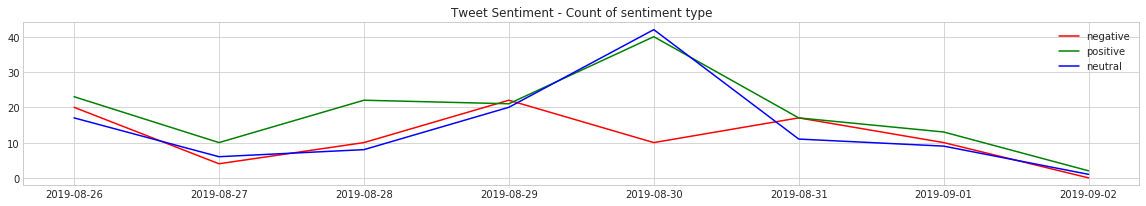

In [26]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20, 3))
plt.plot(daily_count_df.index, daily_count_df.negative, color = 'red')
plt.plot(daily_count_df.index, daily_count_df.positive, color = 'green')
plt.plot(daily_count_df.index, daily_count_df.neutral, color = 'blue')
plt.title("Tweet Sentiment - Count of sentiment type")
#plt.text('2019-08-02', 0.05,"EY minutes released")
plt.legend()

The graph above doesn't tell us a lot over a one week time period. However it would likely be more compelling over a longer timeframe, such as six months. The relative impact of major events on twitter traffic could be measured in this way.

### Summarise most frequent words used

Above we've used hashtags as a way of summarising the topics that are driving positive or negative sentiment. A more general approach is to see which words appear most frequently. The NLTK library helps to structure the text and the WordCloud package provides a nice visual representation.

Preprocessing is required to remove 'stop words' (words too common to provide any meaningful information) as well as punctuation, numbers and links.

In [27]:
!conda install -c conda-forge wordcloud==1.4.1 --yes
from wordcloud import WordCloud, STOPWORDS

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.7 MB

The following NEW packages will be INSTALLED:

    wordcloud:       1.4.1-py36_0      conda-forge

The following packages will be UPDATED:

    ca-certificates: 2019.5.15-1                   --> 2019.6.16-hecc5488_0 conda-forge
    certifi:         2019.6.16-py36_1

In [28]:
from sklearn.feature_extraction import text 
my_additional_stop_word_list = ["amp", "bank","banking", "nab"]
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_word_list)

In [29]:
def clean_tweets(tweet):
    user_removed = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)','',tweet)
    link_removed = re.sub('https?://[A-Za-z0-9./]+','',user_removed)
    number_removed = re.sub('[^a-zA-Z]', ' ', link_removed)
    lower_case_tweet= number_removed.lower()
    tok = WordPunctTokenizer()
    words = tok.tokenize(lower_case_tweet)
    clean_tweet = (' '.join(words)).strip()
    return clean_tweet

clean = lambda x: clean_tweets(x)

In [30]:
tweet_text = pd.DataFrame(df.text.apply(clean))
tweet_text.head()

,text
0,on hold business banking you re experiencing u...
1,not only about me this is much much bigger tha...
2,more than half of the funds on the fat cat lis...
3,seems to be working on firefox but not chrome
4,of the big report mortgage book contractions b...


Now that we have a dataframe of pure tweet text we can count the instances of each word using the countvectorizer function from the Scikit-learn library:

In [31]:
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(tweet_text.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = tweet_text.index
data_dtm.head()

,aati,abandoned,ability,able,absolutely,academically,academy,accelerate,accelerator,accept,...,year,years,yes,yl,yo,young,youre,youtube,zero,zeroday
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
tweet_words = data_dtm.transpose()
tweet_words['Total']=tweet_words.sum(axis=1)
tweet_words.sort_values('Total', ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,...,346,347,348,349,350,351,352,353,354,Total
walsh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
dufferthefluffer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
rising,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
star,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
afl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
sam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18
just,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,16
john,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,13
good,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
business,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13


We now have a sorted list of word frequency, from most-used down to least-used. Lets write a function which turns a dataframe into a wordcloud, then take a look at a couple of wordcloud outputs; one for positive tweets and one for negative sentiment tweets only:

In [33]:
#function takes tweets in pandas series and outputs a word cloud
def tweetcloud(tweets):
    #clean the tweets
    tweet_text = pd.DataFrame(tweets.apply(clean))
    #put all tweets into a string in preparation for wordcloud
    all_text = " ".join(list(tweet_text['text']))
    
    
    # instantiate a word cloud object
    wc = WordCloud(background_color='white', max_words=2000, stopwords = stop_words)

    # generate the word cloud
    wc.generate(all_text)
    
    # display the word cloud
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Top words from positive tweets:


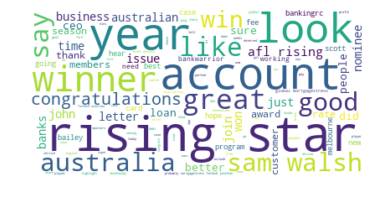

In [34]:
print('Top words from positive tweets:')
tweetcloud(df[df['positive']==1].text)

Top words from negative tweets:


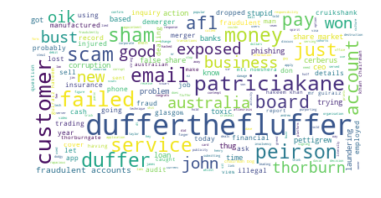

In [35]:
print('Top words from negative tweets:')
tweetcloud(df[df['negative']==1].text)

In [52]:
df.text.str.find('bankwarriors')

0     -1
1     -1
2     -1
3     -1
4     -1
5     -1
6     -1
7     -1
8     -1
9     -1
10    -1
11    -1
12    -1
13    -1
14    -1
15    -1
16    -1
17    -1
18    -1
19    -1
20    -1
21    -1
22    -1
23    -1
24    -1
25    -1
26    -1
27    -1
28    -1
29    -1
      ..
325   -1
326   -1
327   -1
328   -1
329   -1
330   -1
331   -1
332   -1
333   -1
334   -1
335   -1
336   -1
337   -1
338   -1
339   -1
340   -1
341   -1
342   -1
343   -1
344   -1
345   -1
346   -1
347   -1
348   -1
349   -1
350   -1
351   -1
352   -1
353   -1
354   -1
Name: text, Length: 355, dtype: int64

In [51]:
df.text[19]

'@CYBGHungrStrike @davidduffycybg No writ could be served - no debt has been proven. #cerberus is @NAB laundering. @davidduffycybg #dufferthefluffer has failed and he knows. His bank @clydesdalebank is trading bust. @cybgplc is a sham. No merger with @virginmoney . False share market. @LSEplc @Tabby_Kinder https://t.co/Mp7oMrqXnq'